# Export variables for validation
- This script is used to plot variables from simulations and observations;
- Simulations: CNTL, TRAF at FR-Capitole. 

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cftime
import string
import matplotlib.dates as mdates
home_path = '/gws/nopw/j04/duicv/yuansun/'

In [2]:
psites = ["FR-Capitole"]
msites = ["FR-Cap"]
START = ['1994']
END = ['2005']
var0 = ['LWdown', 'SWdown']
var1 = ['LWdown', 'SWdown','LWup', 'SWup', 'Qh', 'Qle', 'Qtau']
var2 = ['FIRE_U', 'FSR', 'FSH_U', 'EFLX_LH_TOT_U', 'TAUX']
zone = [1]
start_date = ['2004-02-20T00:30:00']
end_date = ['2005-02-28T22:30:00']
mid_date = [['2004-06-01T00:00:00', '2004-12-01T00:00:00']]

In [3]:
sequence = ['Rn', 'SWup', 'LWup', 'Qh', 'Qle', 'Qtau']
sequence2 = ['$R_{n}$', '$SW_{up}$', '$LW_{up}$', '$Q_{h}$', '$Q_{le}$', '$Q_{tau}$']
entity = ['obs', 'cntl', 'traf']
label1 = ['Observation: mean', 
          'CNTL: mean', 
          'TRAF: mean']
label2 = ['Observation: 5%-95%', 
          'CNTL: 5%-95%', 
          'TRAF: 5%-95%']
#lc0 = '#083550'
#lc1 = '#006bac'
#lc2 = '#3da4e3'
#lc3 = '#6c64d4'
lc0 = '#1b9e77'
lc1 = '#d95f02'
lc2 = '#7570b3'
lc3 = '#e7298a'
lc4 = '#66a61e'
lc = [lc0, lc1, lc2, lc3, lc4]
alpha = [0.1, 0.1, 0.1, 0.1, 0.1]
labelfont = 6
linewidth = 0.5
labelcolor = '#6b6b6b'
padding = 4
metric = ['7-day mean', 'Diurnal mean']
pad = 1
xwidth = 0.5
length = 2
handletextpad = 0.5

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))
ax_ymin_list = [-100, 0, 300, -100, -50, 0]
ax_ymax_list = [700, 120, 700, 400, 150, 1]
ax2_ymin_list = [-6, -0.2, 2, 10, -4, 0]
ax2_ymax_list = [-2,   0.2,  6, 22, 8, 0.04]

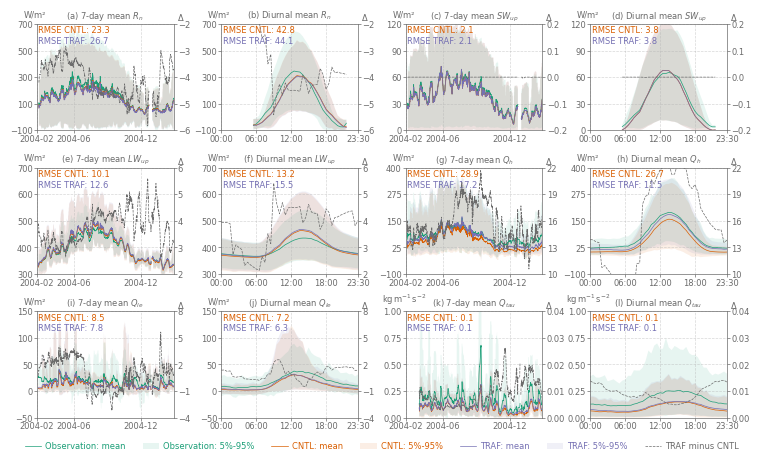

In [7]:
for sitesequence in range(len(psites)):
    GRIDNAME = psites[sitesequence]
    mid_time = mid_date[sitesequence]
    df = pd.read_csv(f'data_for_figure/{GRIDNAME}.csv')
    df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
    diurnal_mean = df.groupby('diurnal').mean(numeric_only=True).reset_index()
    diurnal_5 = df.groupby('diurnal').quantile(0.05).reset_index()
    diurnal_95 = df.groupby('diurnal').quantile(0.95).reset_index()

    numeric_cols = df.columns
    cols = numeric_cols.drop(['time', 'hour', 'minute','diurnal'])
    seven_day_mean = df[cols].rolling(window=336, min_periods=48).mean().reset_index()
    seven_day_5 = df[cols].rolling(window=336, min_periods=48).quantile(0.05).reset_index()
    seven_day_95 = df[cols].rolling(window=336, min_periods=48).quantile(0.95).reset_index()
    
    fig, axs = plt.subplots(3, 4, figsize=(7.5, 4.5))
    axs = axs.flatten()
    for i in range(12):
        col_name_obs = sequence[i//2]+'_' + entity[0]
        col_name_cntl = sequence[i//2]+'_' + entity[1]
        col_name_traf = sequence[i//2]+'_' + entity[2]
        ax2 = axs[i].twinx()
        ax_ymin = ax_ymin_list[i//2]
        ax_ymax = ax_ymax_list[i//2]
        ax2_ymin = ax2_ymin_list[i//2]
        ax2_ymax = ax2_ymax_list[i//2]
        axs[i].set_ylim([ax_ymin, ax_ymax])
        ax2.set_ylim([ax2_ymin, ax2_ymax])
        axs[i].set_yticks([ax_ymin, ax_ymin+(ax_ymax-ax_ymin)/4 , (ax_ymin + ax_ymax)/2 , ax_ymax-(ax_ymax-ax_ymin)/4, ax_ymax])
        ax2.set_yticks([ax2_ymin, ax2_ymin+(ax2_ymax-ax2_ymin)/4 , (ax2_ymin + ax2_ymax)/2 , ax2_ymax-(ax2_ymax-ax2_ymin)/4, ax2_ymax])
        for spin in ax2.spines.values():
            spin.set_visible(False) 
        if i%2==0: # analyse period
            for j in range(len(entity)):
                col_name = sequence[i//2]+'_' + entity[j]
                axs[i].plot(df.time, seven_day_mean[col_name], label=label1[j], color=lc[j], linewidth=linewidth)
                axs[i].fill_between(df.time, seven_day_5[col_name], seven_day_95[col_name], alpha=alpha[j], color=lc[j],  edgecolor='none', label=label2[j])
            #xticks = [df['time'].iloc[0]] + mid_time + [df['time'].iloc[-1]]
            xticks = [df['time'].iloc[0]] + mid_time
            axs[i].set_xticks(xticks)
                #axs[i].set_xticks([df.time.iloc[0], mid_time, df.time.iloc[-1]])
            axs[i].set_xlim([df.time.iloc[0], df.time.iloc[-1]])
            axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

            axs[i].text(0.01,0.9,'RMSE CNTL: {:.1f}'.format(rmse(seven_day_mean[col_name_cntl] , seven_day_mean[col_name_obs])),
                    fontsize=labelfont, color=lc[1], horizontalalignment='left',
                           verticalalignment='bottom', transform=axs[i].transAxes)
            axs[i].text(0.01,0.8,'RMSE TRAF: {:.1f}'.format(rmse(seven_day_mean[col_name_traf] , seven_day_mean[col_name_obs])),
                    fontsize=labelfont, color=lc[2], horizontalalignment='left',
                           verticalalignment='bottom', transform=axs[i].transAxes)   
            ax2.plot(df.time, seven_day_mean[col_name_traf] - seven_day_mean[col_name_cntl], label='TRAF minus CNTL', color=labelcolor, linewidth=linewidth, linestyle='--') 
        elif i%2==1: # dinural time variation
            for j in range(len(entity)):
                col_name = sequence[i//2]+'_' + entity[j]
                axs[i].plot(diurnal_mean.diurnal, diurnal_mean[col_name], label=entity[j], color=lc[j], linewidth=linewidth)
                axs[i].fill_between(diurnal_mean.diurnal, diurnal_5[col_name], diurnal_95[col_name], alpha=alpha[j], color=lc[j],  edgecolor='none')
            axs[i].set_xticks([diurnal_mean.diurnal.iloc[0], '06:00', '12:00', '18:00', diurnal_mean.diurnal.iloc[-1]])
            axs[i].set_xlim([diurnal_mean.diurnal.iloc[0], diurnal_mean.diurnal.iloc[-1]])
             
            axs[i].text(0.01,0.9,'RMSE CNTL: {:.1f}'.format(rmse(diurnal_mean[col_name_cntl], diurnal_mean[col_name_obs])),
                    fontsize=labelfont, color=lc[1], horizontalalignment='left',
                           verticalalignment='bottom', transform=axs[i].transAxes)
            axs[i].text(0.01,0.8,'RMSE TRAF: {:.1f}'.format(rmse(diurnal_mean[col_name_traf] , diurnal_mean[col_name_obs])),
                    fontsize=labelfont, color=lc[2], horizontalalignment='left',
                           verticalalignment='bottom', transform=axs[i].transAxes)
            ax2.plot(diurnal_mean.diurnal, diurnal_mean[col_name_traf] - diurnal_mean[col_name_cntl], label='TRAF minus CNTL', color=labelcolor, linewidth=linewidth, linestyle='--')
        axs[i].set_title(f'({string.ascii_lowercase[i]}) {metric[i%2]} {sequence2[i//2]}',fontsize=labelfont,color=labelcolor, pad = padding)   
        axs[i].set_ylabel('W/m²',labelpad=5, rotation=0, ha='center', fontsize=labelfont,color=labelcolor)
        axs[i].yaxis.set_label_coords(-0.05, 1.1)
        axs[i].tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelcolor=labelcolor, color=labelcolor,labelsize=labelfont,pad=pad, width = xwidth, length = length)
        axs[i].tick_params(axis='x', which='both', top=False, bottom=True, labelbottom=True, labelcolor=labelcolor,color=labelcolor,labelsize=labelfont,pad=pad, width = xwidth, length = length)
        for spine in axs[i].spines.values():
            spine.set_linewidth(xwidth)
            spine.set_edgecolor(labelcolor)
        ax2.tick_params(axis='y', which='both', left=False, right=True, labelright=True, labelcolor=labelcolor, color=labelcolor,labelsize=labelfont,pad=pad, width = xwidth, length = length) 
        ax2.set_ylabel(r'$\Delta$',labelpad=5, rotation=0, ha='center', fontsize=labelfont,color=labelcolor)
        ax2.yaxis.set_label_coords(1.05, 1.115)   
        axs[i].grid(True,linestyle='--',linewidth=0.5, alpha=0.5)
        if i >=10:
            axs[i].set_ylabel(r'$\mathrm{kg \, m^{-1} \, s^{-2}}$', labelpad=5, rotation=0, ha='center', fontsize=labelfont,color=labelcolor)
        else:    
            axs[i].set_ylabel('W/m²', labelpad=5, rotation=0, ha='center', fontsize=labelfont,color=labelcolor)
        axs[i].yaxis.set_label_coords(-0.015, 1.05)
    plt.subplots_adjust(left=0.04, right=0.96, bottom=0.075, top=0.95, wspace=0.35, hspace= 0.35)
    lines1, labels1 = axs[0].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines = lines1 + lines2
    labels = labels1 + labels2
    legend = fig.legend(lines, labels, bbox_to_anchor=(0.5, -0.015), loc='lower center', frameon=False, 
                        handletextpad=handletextpad, fontsize=labelfont, ncol=7)
    llc = [lc0, lc0, lc1, lc1, lc2, lc2, labelcolor]
    for i, text in enumerate(legend.get_texts()):
        text.set_color(llc[i])
    #plt.suptitle('Timeseries and diurnal plots for ' + GRIDNAME, fontsize=labelfont+2, color=labelcolor,x=0.5, y=0.99, ha='center', va='top')
    
    fig.savefig(f'{GRIDNAME}.png', dpi=300)
    fig.savefig(f'{GRIDNAME}.pdf', dpi=600)

# Description

In [4]:
df = pd.read_csv('data_for_figure/FR-Capitole.csv')
df = df[:-427]
df

,time,LWdown_obs,SWdown_obs,LWup_obs,SWup_obs,Qh_obs,Qle_obs,Qtau_obs,Rn_obs,LWup_cntl,...,Rn_cntl,LWup_traf,SWup_traf,Qh_traf,Qle_traf,Qtau_traf,Rn_traf,hour,minute,diurnal
0,2004-02-20 01:00:00,223.27434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,02:00
1,2004-02-20 01:30:00,223.62167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,30,02:30
2,2004-02-20 02:00:00,223.69900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,03:00
3,2004-02-20 02:30:00,224.90567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,30,03:30
4,2004-02-20 03:00:00,222.67833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,0,04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17564,2005-02-19 23:00:00,272.38666,NaN,329.89300,NaN,22.021,22.924,0.186779,NaN,322.98373,...,NaN,325.61100,NaN,-0.124090,17.054476,0.071788,NaN,0,0,00:00
17565,2005-02-19 23:30:00,265.89334,NaN,329.11566,NaN,10.515,17.025,0.114205,NaN,321.70350,...,NaN,324.36618,NaN,-3.853172,17.140480,0.067527,NaN,0,30,00:30
17566,2005-02-20 00:00:00,247.53267,NaN,326.82233,NaN,7.242,17.218,0.087173,NaN,318.54727,...,NaN,321.33258,NaN,-7.759286,14.381461,0.050079,NaN,1,0,01:00
17567,2005-02-20 00:30:00,234.91766,NaN,324.80432,NaN,22.306,10.102,0.167303,NaN,316.98663,...,NaN,319.18552,NaN,-8.609348,10.876901,0.055126,NaN,1,30,01:30


In [16]:
np.round(df['LWup_traf'].mean() - df['LWup_cntl'].mean(),2)

np.float64(3.81)

In [17]:
np.round(df['Qh_traf'].mean() - df['Qh_cntl'].mean(),2)

np.float64(15.65)

In [18]:
np.round(df['Qle_traf'].mean() - df['Qle_cntl'].mean(),2)

np.float64(1.0)